<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Chapter 1

In [21]:
# data prep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

online = pd.read_csv('online.csv', parse_dates=['InvoiceDate'], index_col=0)
online.info()

import datetime as dt

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70864 entries, 416792 to 312243
Data columns (total 8 columns):
InvoiceNo      70864 non-null int64
StockCode      70864 non-null object
Description    70864 non-null object
Quantity       70864 non-null int64
InvoiceDate    70864 non-null datetime64[ns]
UnitPrice      70864 non-null float64
CustomerID     70864 non-null int64
Country        70864 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 4.9+ MB


In [22]:
# Define a function that will parse the date
def get_day(x): return dt.datetime(x.year, x.month, x.day) 

# Create InvoiceDay column
online['InvoiceDay'] = online['InvoiceDate'].apply(get_day) 

# Group by CustomerID and select the InvoiceDay value
grouping = online.groupby('CustomerID')['InvoiceDay'] 

# Assign a minimum InvoiceDay value to the dataset
# i.e. the first order.. not used transform before...
online['CohortDay'] = grouping.transform('min')

# View the top 5 rows
print(online.head())

        InvoiceNo StockCode                      Description  Quantity  \
416792     572558     22745       POPPY'S PLAYHOUSE BEDROOM          6   
482904     577485     23196    VINTAGE LEAF MAGNETIC NOTEPAD         1   
263743     560034     23299     FOOD COVER WITH BEADS SET 2          6   
495549     578307    72349B  SET/6 PURPLE BUTTERFLY T-LIGHTS         1   
204384     554656     21756         BATH BUILDING BLOCK WORD         3   

               InvoiceDate  UnitPrice  CustomerID         Country InvoiceDay  \
416792 2011-10-25 08:26:00       2.10       14286  United Kingdom 2011-10-25   
482904 2011-11-20 11:56:00       1.45       16360  United Kingdom 2011-11-20   
263743 2011-07-14 13:35:00       3.75       13933  United Kingdom 2011-07-14   
495549 2011-11-23 15:53:00       2.10       17290  United Kingdom 2011-11-23   
204384 2011-05-25 13:36:00       5.95       17663  United Kingdom 2011-05-25   

        CohortDay  
416792 2011-04-11  
482904 2011-09-12  
263743 2011-07

In [25]:
idx = online['CustomerID'] == 14286
online.loc[idx, 'InvoiceDate'].min()

Timestamp('2011-04-11 08:16:00')

In [26]:
# data prep
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

# Get the integers for date parts from the `InvoiceDay` column
invoice_year, invoice_month, invoice_day = get_date_int(online, 'InvoiceDay')

# Get the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, cohort_day = get_date_int(online, 'CohortDay')

In [42]:
# Calculate difference in years
years_diff =  invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Calculate difference in days
days_diff = invoice_day - cohort_day

# Extract the difference in days from all previous values
online['CohortIndex'] = years_diff * 365 + months_diff * 30 + days_diff + 1
print(online.head())

        InvoiceNo StockCode                      Description  Quantity  \
416792     572558     22745       POPPY'S PLAYHOUSE BEDROOM          6   
482904     577485     23196    VINTAGE LEAF MAGNETIC NOTEPAD         1   
263743     560034     23299     FOOD COVER WITH BEADS SET 2          6   
495549     578307    72349B  SET/6 PURPLE BUTTERFLY T-LIGHTS         1   
204384     554656     21756         BATH BUILDING BLOCK WORD         3   

               InvoiceDate  UnitPrice  CustomerID         Country InvoiceDay  \
416792 2011-10-25 08:26:00       2.10       14286  United Kingdom 2011-10-25   
482904 2011-11-20 11:56:00       1.45       16360  United Kingdom 2011-11-20   
263743 2011-07-14 13:35:00       3.75       13933  United Kingdom 2011-07-14   
495549 2011-11-23 15:53:00       2.10       17290  United Kingdom 2011-11-23   
204384 2011-05-25 13:36:00       5.95       17663  United Kingdom 2011-05-25   

        CohortDay  CohortIndex CohortMonth  
416792 2011-04-11          19

In [43]:
# data prep
# Turn day into month - roughly...
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

online['CohortIndex'] = online['CohortIndex'] // 30 + 1
online['CohortMonth'] = online['CohortDay'].apply(get_month)
grouping = online.groupby(['CohortMonth', 'CohortIndex'])

# Count the number of unique values per customer ID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

# Create a pivot 
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis='rows')

In [44]:
retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,1.0,0.343575,0.326816,0.347765,0.344972,0.393855,0.354749,0.329609,0.326816,0.364525,0.375698,0.491620,0.181564
2011-01-01,1.0,0.222892,0.277108,0.295181,0.280120,0.268072,0.256024,0.277108,0.307229,0.364458,0.262048,0.018072,NaN
2011-02-01,1.0,0.212025,0.224684,0.272152,0.202532,0.256329,0.250000,0.240506,0.306962,0.237342,0.015823,NaN,NaN
2011-03-01,1.0,0.193299,0.247423,0.206186,0.193299,0.195876,0.237113,0.247423,0.213918,0.030928,NaN,NaN,NaN
2011-04-01,1.0,0.223529,0.168627,0.211765,0.168627,0.200000,0.254902,0.180392,0.031373,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.164659,0.156627,0.180723,0.216867,0.253012,0.228916,0.012048,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.149758,0.159420,0.178744,0.256039,0.251208,0.028986,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.138728,0.196532,0.231214,0.231214,0.005780,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.201439,0.280576,0.179856,0.014388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = online.groupby(['CohortMonth', 'CohortIndex']) 

# Calculate the average of the unit price column
cohort_data = grouping['UnitPrice'].mean()

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

# Create a pivot 
average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='UnitPrice')
print(average_quantity.round(1))

CohortIndex   1    2    3    4    5    6    7    8    9    10   11   12   13
CohortMonth                                                                 
2010-12-01   3.0  3.0  3.1  2.8  2.7  6.9  2.9  2.9  2.7  2.6  3.0  2.9  2.5
2011-01-01   3.2  2.9  3.1  3.1  3.3  2.8  2.5  2.6  3.0  2.7  2.4  1.9  NaN
2011-02-01   3.1  3.7  3.2  2.9  3.4  2.9  2.8  2.7  2.9  2.6  3.2  NaN  NaN
2011-03-01   3.5  3.8  3.4  2.7  2.6  2.4  2.8  2.8  2.5  2.6  NaN  NaN  NaN
2011-04-01   3.3  4.0  3.4  2.9  2.6  2.8  2.8  2.6  2.1  NaN  NaN  NaN  NaN
2011-05-01   3.1  2.7  2.7  2.5  2.2  2.3  2.8  1.2  NaN  NaN  NaN  NaN  NaN
2011-06-01   2.8  2.0  3.5  2.6  2.5  2.4  2.9  NaN  NaN  NaN  NaN  NaN  NaN
2011-07-01   3.2  4.1  2.5  2.6  2.2  1.2  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2011-08-01   3.2  3.3  7.5  4.0  5.3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2011-09-01   2.9  3.2  2.8  1.6  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2011-10-01   2.9  2.7  2.5  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

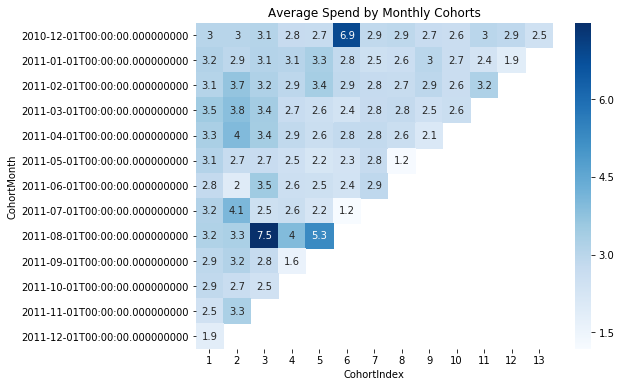

In [46]:
# Import seaborn package as sns
import seaborn as sns

# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(8, 6))

# Add a title
plt.title('Average Spend by Monthly Cohorts')

# Create the heatmap
sns.heatmap(average_quantity, annot=True, cmap='Blues')
plt.show()